<center>
<b><i><font color="Sky Blue" size="8">Odi Cricket Analysis</font></i></b>
</center>

<h2><b><font color="gold">Introduction</font></b></h2>

In [217]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [218]:
# Importing Requires Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [219]:
# Path for files from drive
odi_ball_file = '/content/drive/MyDrive/Cricket_Project/data/model_ready/Ball By Ball/odi_ball_by_ball.csv'
odi_info_file = '/content/drive/MyDrive/Cricket_Project/data/model_ready/Info/odi_info.csv'
odi_summary_file = '/content/drive/MyDrive/Cricket_Project/data/model_ready/Summary/odi_summary.csv'

# Loading the CSV's into a DataFrame
df_odi_ball = pd.read_csv(odi_ball_file, low_memory=False)
df_odi_info = pd.read_csv(odi_info_file, low_memory=False)
df_odi_summary = pd.read_csv(odi_summary_file, low_memory=False)

In [220]:
# Verifying the shape of Dataframes

print(f"Ball By Ball shape: {df_odi_ball.shape}")
print(f"Info shape: {df_odi_info.shape}")
print(f"Summary shape: {df_odi_summary.shape}")

Ball By Ball shape: (1304637, 16)
Info shape: (2460, 2357)
Summary shape: (2460, 21)


<h2><b><font color="gold">Data Cleaning</font></b></h2>

In [221]:
# Checking for missing values in each column
missing_counts = df_odi_ball.isnull().sum()
print(missing_counts)



batter                     0
bowler                     0
non_striker                0
batting_team               0
over                       0
team                       0
runs.batter                0
runs.extras                0
runs.total                 0
extras.wides               0
extras.legbyes             0
extras.byes                0
extras.noballs             0
wicket.kind          1269010
wicket.player_out    1269010
Match Id                   0
dtype: int64


In [222]:
# Remove columns with all missing values
df_odi_ball.dropna(axis=1, how='all', inplace=True)


if 'batsman_runs' in df_odi_ball.columns:
    df_odi_ball['batsman_runs'] = df_odi_ball['batsman_runs'].fillna(0)
if 'extras' in df_odi_ball.columns:
    df_odi_ball['extras'] = df_odi_ball['extras'].fillna(0)
if 'bowler' in df_odi_ball.columns:
    df_odi_ball['bowler'] = df_odi_ball['bowler'].fillna("Unknown")


if 'wicket.kind' in df_odi_ball.columns:
    df_odi_ball['is_wicket'] = df_odi_ball['wicket.kind'].notnull().astype(int)
else:
    df_odi_ball['is_wicket'] = 0

In [223]:
# Renaming columns for better readability

df_odi_ball = df_odi_ball.rename(columns={
    'runs.batter': 'batsman_runs',
    'runs.extras': 'extras',
    'runs.total': 'total_runs'
})


<h2><b><font color="gold">Data Pre-Processing</font></b></h2>

In [224]:
# Standardizing the Match ID Column Name

for df in [df_odi_ball, df_odi_info]:
    if 'Match Id' in df.columns:
        df.rename(columns={'Match Id': 'Match_ID'}, inplace=True)

In [225]:
# Removing unnesasary columns before merging

required_info_cols = [
    'Match_ID', 'balls_per_over', 'city', 'dates', 'event.name',
    'event.match_number', 'gender', 'match_type', 'match_type_number',
    'season', 'teams', 'player_of_match', 'outcome.winner', 'outcome.by.runs',
    'outcome.by.wickets', 'outcome.result', 'outcome.summary', 'venue'
]

# Use only columns present in your file

df_odi_info = df_odi_info[[col for col in required_info_cols if col in df_odi_info.columns]].copy()

In [226]:
# Merging Ball data and Info data

df_odi_ball = df_odi_ball.merge(df_odi_info, on='Match_ID', how='left')

<h2><b><font color="gold">Finding batting team and opponent team for better analysis</font></b></h2>

In [227]:
# Finding opponent team

def get_opposition(row):

    teams = row['teams']
    if isinstance(teams, list):
        pass
    elif isinstance(teams, str):
        teams = [t.strip() for t in teams.split(',')]
    else:
        return None

    if row['batting_team'] == teams[0]:
        return teams[1]
    elif row['batting_team'] == teams[1]:
        return teams[0]
    else:
        return None

df_odi_ball['opposition'] = df_odi_ball.apply(get_opposition, axis=1)


In [228]:
# Finding Batting Team

def find_batting_team(row):
    """
    This function returns the team name (from 'team_list') that the 'batter' plays for,
    using the players.<team_name> columns in the same DataFrame.
    """
    for t in row['team_list']:
        player_col = f"players.{t}"
        players = row.get(player_col, [])
        if isinstance(players, str):
            import ast
            try:
                players = ast.literal_eval(players)
            except Exception:
                players = [p.strip() for p in players.split(',')]
        if row['batter'] in players:
            return t
    return None

<h2><b><font color="gold">Overall analysis visualizations</font></b></h2>


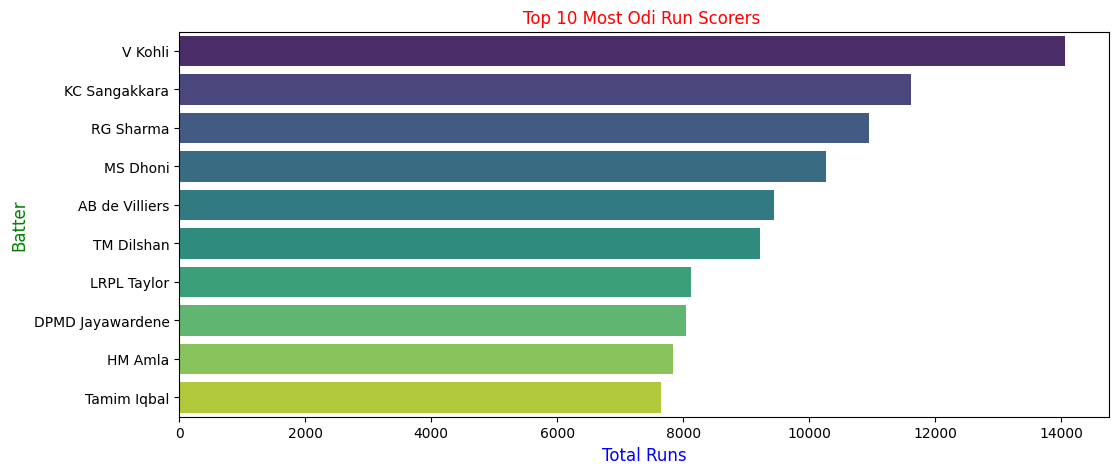

In [229]:
# Most Runs scored Battters in odi

plt.figure(figsize=(12,5))
top_batsmen = df_odi_ball.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False).head(10)
sns.barplot(
    x=top_batsmen.values,
    y=top_batsmen.index,
    hue=top_batsmen.index,
    palette="viridis",
    legend=False
)

plt.title("Top 10 Most Odi Run Scorers ", color = 'red')
plt.xlabel("Total Runs",  color='blue', fontsize=12)
plt.ylabel("Batter", color='green', fontsize=12)
plt.show()


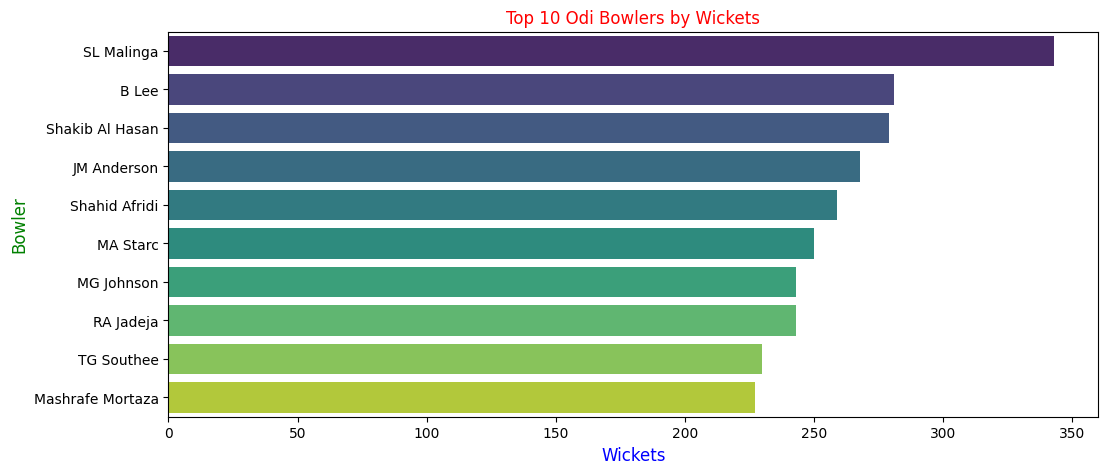

In [230]:
# Most wicket taking bowlers in odi

plt.figure(figsize=(12,5))
top_bowlers = df_odi_ball[df_odi_ball['is_wicket']==1].groupby('bowler').size().sort_values(ascending=False).head(10)
sns.barplot(
    x=top_bowlers.values,
    y=top_bowlers.index,
    hue=top_bowlers.index,
    palette="viridis",
    legend=False
)
plt.xlabel('Wickets', color='blue', fontsize=12)
plt.ylabel('Bowler', color='green', fontsize=12)
plt.title('Top 10 Odi Bowlers by Wickets', color = 'red')
plt.show()

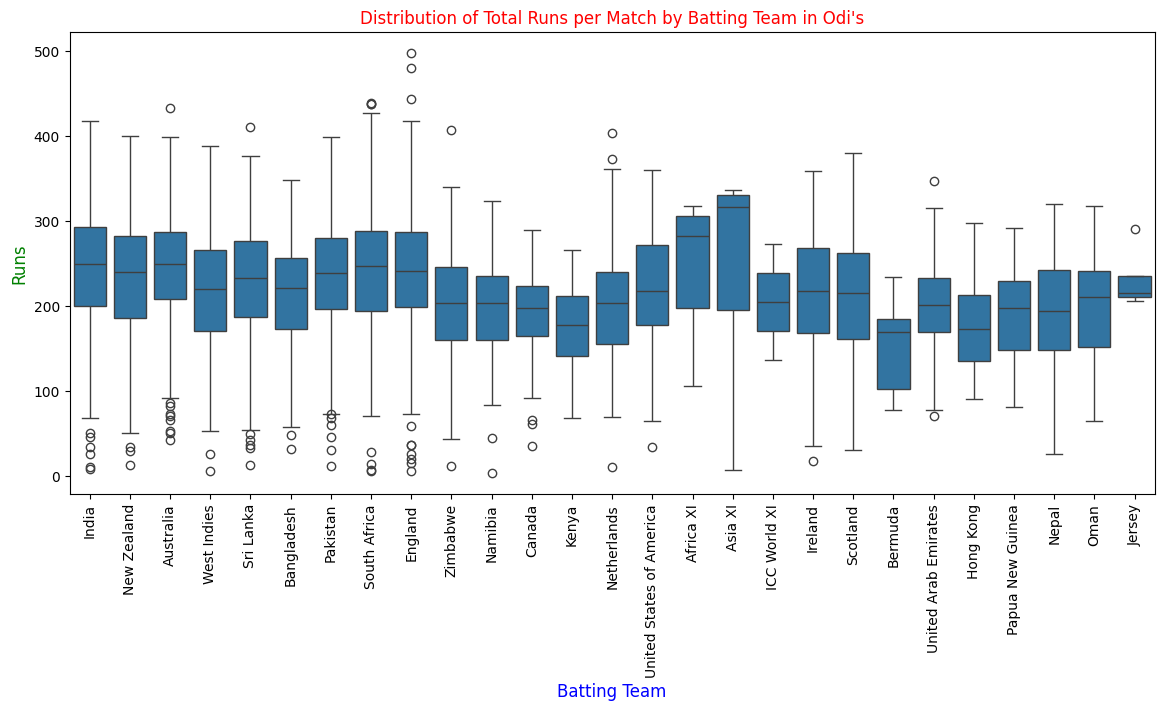

In [231]:
# Total runs scored team for match

runs_per_innings = df_odi_ball.groupby(['Match_ID', 'batting_team'])['total_runs'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.boxplot(x='batting_team', y='total_runs', data=runs_per_innings)
plt.title("Distribution of Total Runs per Match by Batting Team in Odi's", color = 'red')
plt.xlabel("Batting Team",  color='blue', fontsize=12)
plt.ylabel("Runs", color='green', fontsize=12)
plt.xticks(rotation=90)
plt.show()

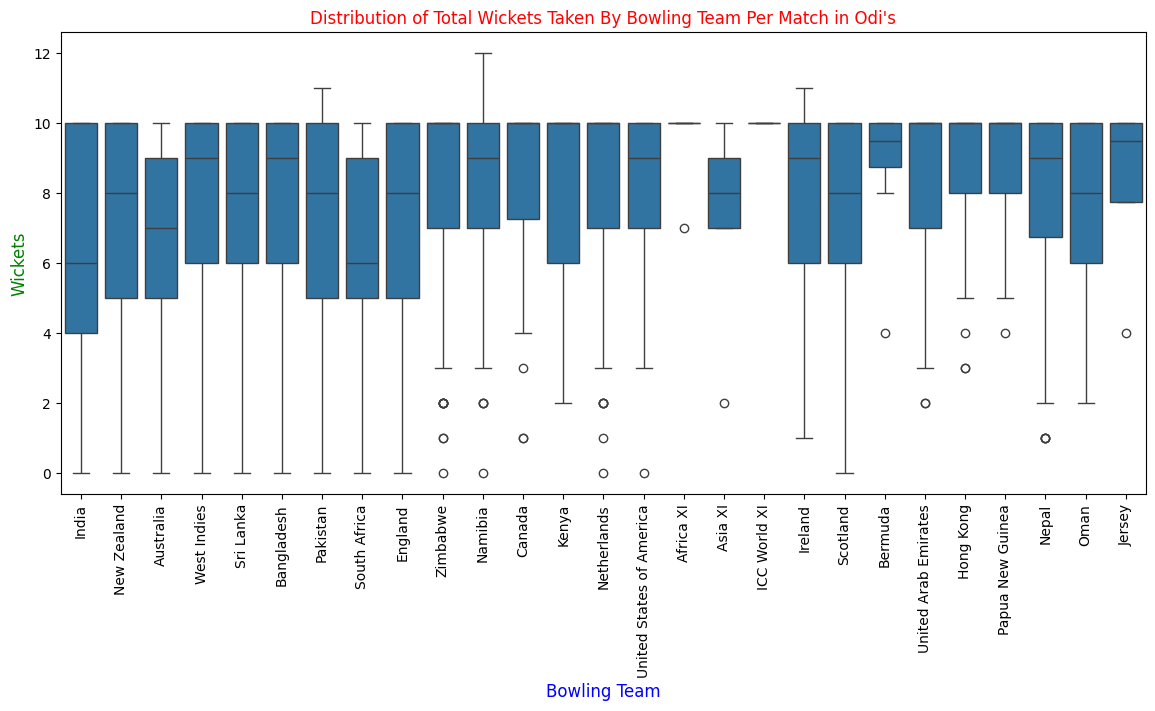

In [232]:
# Total Wickets taken by Bowling team per match

wickets_per_innings = df_odi_ball.groupby(['Match_ID', 'team'])['is_wicket'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.boxplot(x='team', y='is_wicket', data=wickets_per_innings)
plt.title("Distribution of Total Wickets Taken By Bowling Team Per Match in Odi's", color = 'red')
plt.xlabel("Bowling Team", color='blue', fontsize=12)
plt.ylabel("Wickets", color='green', fontsize=12)
plt.xticks(rotation=90)
plt.show()


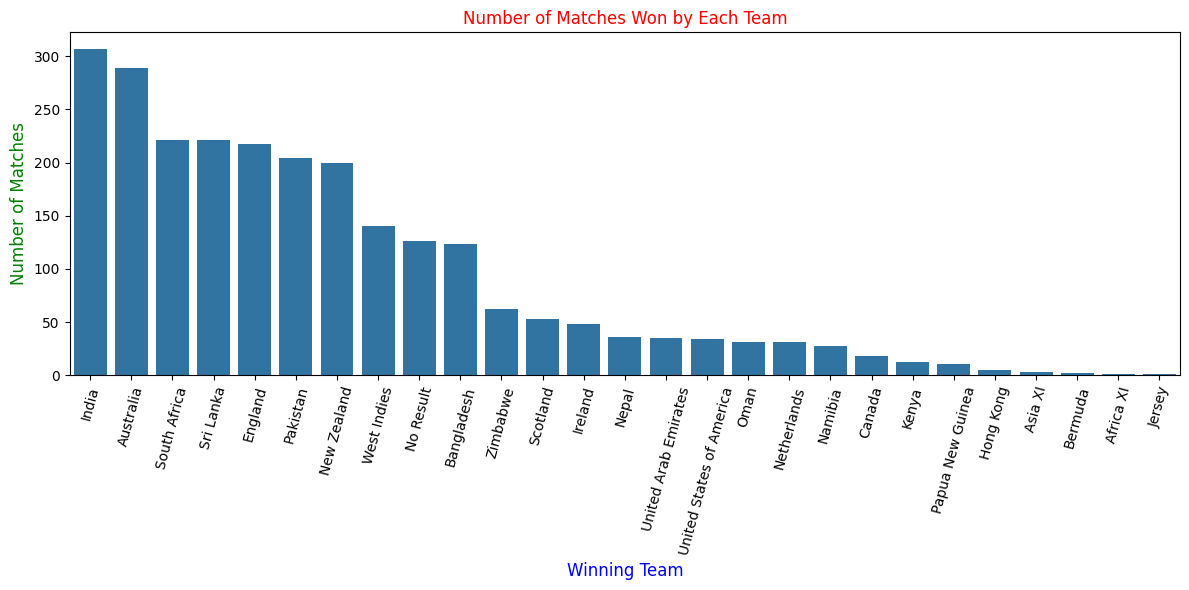

In [233]:
# Number of matches won by each team

df_odi_info['outcome.winner'] = df_odi_info['outcome.winner'].fillna('No Result')
plt.figure(figsize=(12,6))
winner_counts = df_odi_info['outcome.winner'].value_counts().reset_index()
winner_counts.columns = ['Winner', 'Count']
ax = sns.barplot(data=winner_counts, x='Winner', y='Count')
plt.title("Number of Matches Won by Each Team", color = 'red')
plt.xlabel("Winning Team", color='blue', fontsize=12)
plt.ylabel("Number of Matches", color='green', fontsize=12)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

<h2><b><font color="gold">venue Mapping for further Analysis</font></b></h2>

In [234]:
venue_mapping_odi = {
    # Arnos Vale
    "Arnos Vale Ground, Kingstown, St Vincent": "Arnos Vale Ground",
    "Arnos Vale Ground, Kingstown": "Arnos Vale Ground",
    "Arnos Vale Ground": "Arnos Vale Ground",

    # Arun Jaitley
    "Arun Jaitley Stadium, Delhi": "Arun Jaitley Stadium",
    "Arun Jaitley Stadium": "Arun Jaitley Stadium",

    # Bangabandhu
    "Bangabandhu National Stadium, Dhaka": "Bangabandhu National Stadium",
    "Bangabandhu National Stadium": "Bangabandhu National Stadium",

    # Barabati
    "Barabati Stadium, Cuttack": "Barabati Stadium",
    "Barabati Stadium": "Barabati Stadium",

    # Barsapara
    "Barsapara Cricket Stadium, Guwahati": "Barsapara Cricket Stadium",
    "Barsapara Cricket Stadium": "Barsapara Cricket Stadium",

    # Basin Reserve
    "Basin Reserve, Wellington": "Basin Reserve",
    "Basin Reserve": "Basin Reserve",

    # Bay Oval
    "Bay Oval, Mount Maunganui": "Bay Oval",
    "Bay Oval": "Bay Oval",

    # Bellerive
    "Bellerive Oval, Hobart": "Bellerive Oval",
    "Bellerive Oval": "Bellerive Oval",

    # Boland
    "Boland Bank Park, Paarl": "Boland Park",
    "Boland Park, Paarl": "Boland Park",
    "Boland Park": "Boland Park",

    # Brisbane
    "Brisbane Cricket Ground, Woolloongabba, Brisbane": "Brisbane Cricket Ground",
    "Brisbane Cricket Ground, Woolloongabba": "Brisbane Cricket Ground",
    "Brisbane Cricket Ground": "Brisbane Cricket Ground",

    # Buffalo
    "Buffalo Park, East London": "Buffalo Park",
    "Buffalo Park": "Buffalo Park",

    # Cambusdoon New Ground
    "Cambusdoon New Ground, Ayr": "Cambusdoon New Ground",
    "Cambusdoon New Ground": "Cambusdoon New Ground",

    # Captain Roop Singh
    "Captain Roop Singh Stadium, Gwalior": "Captain Roop Singh Stadium",
    "Captain Roop Singh Stadium": "Captain Roop Singh Stadium",

    # Castle Avenue
    "Castle Avenue, Dublin": "Castle Avenue",
    "Castle Avenue": "Castle Avenue",

    # Central Broward
    "Central Broward Regional Park Stadium Turf Ground, Lauderhill": "Central Broward Regional Park Stadium Turf Ground",
    "Central Broward Regional Park Stadium Turf Ground": "Central Broward Regional Park Stadium Turf Ground",

    # Civil Service
    "Civil Service Cricket Club, Stormont, Belfast": "Civil Service Cricket Club, Stormont",
    "Civil Service Cricket Club, Stormont": "Civil Service Cricket Club, Stormont",

    # Clontarf
    "Clontarf Cricket Club Ground, Dublin": "Clontarf Cricket Club Ground",
    "Clontarf Cricket Club Ground": "Clontarf Cricket Club Ground",

    # County Ground
    "County Ground, Bristol": "County Ground",
    "County Ground, Chelmsford": "County Ground",
    "County Ground": "County Ground",

    # Daren Sammy
    "Daren Sammy National Cricket Stadium, Gros Islet": "Daren Sammy National Cricket Stadium",
    "Darren Sammy National Cricket Stadium, St Lucia": "Daren Sammy National Cricket Stadium",
    "Daren Sammy National Cricket Stadium": "Daren Sammy National Cricket Stadium",

    # De Beers/Diamond Oval
    "De Beers Diamond Oval, Kimberley": "Diamond Oval",
    "De Beers Diamond Oval": "Diamond Oval",
    "Diamond Oval, Kimberley": "Diamond Oval",
    "Diamond Oval": "Diamond Oval",

    # Dr YSR ACA-VDCA
    "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam": "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium",
    "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium": "Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium",

    # Eden Gardens
    "Eden Gardens, Kolkata": "Eden Gardens",
    "Eden Gardens": "Eden Gardens",

    # Eden Park
    "Eden Park, Auckland": "Eden Park",
    "Eden Park": "Eden Park",

    # Edgbaston
    "Edgbaston, Birmingham": "Edgbaston",
    "Edgbaston": "Edgbaston",

    # Gaddafi
    "Gaddafi Stadium, Lahore": "Gaddafi Stadium",
    "Gaddafi Stadium": "Gaddafi Stadium",

    # Goodyear Park
    "Goodyear Park, Bloemfontein": "Goodyear Park",
    "Goodyear Park": "Goodyear Park",

    # Grange
    "Grange Cricket Club Ground, Raeburn Place, Edinburgh": "Grange Cricket Club Ground",
    "Grange Cricket Club, Raeburn Place": "Grange Cricket Club Ground",
    "Grange Cricket Club Ground, Raeburn Place": "Grange Cricket Club Ground",
    "Grange Cricket Club Ground": "Grange Cricket Club Ground",

    # Greenfield
    "Greenfield International Stadium, Thiruvananthapuram": "Greenfield International Stadium",
    "Greenfield International Stadium": "Greenfield International Stadium",

    # Gymkhana
    "Gymkhana Club Ground, Nairobi": "Gymkhana Club Ground",
    "Gymkhana Club Ground": "Gymkhana Club Ground",

    # Hagley
    "Hagley Oval, Christchurch": "Hagley Oval",
    "Hagley Oval": "Hagley Oval",

    # Headingley
    "Headingley, Leeds": "Headingley",
    "Headingley": "Headingley",

    # Himachal Pradesh
    "Himachal Pradesh Cricket Association Stadium, Dharamsala": "Himachal Pradesh Cricket Association Stadium",
    "Himachal Pradesh Cricket Association Stadium": "Himachal Pradesh Cricket Association Stadium",

    # Holkar
    "Holkar Cricket Stadium, Indore": "Holkar Cricket Stadium",
    "Holkar Cricket Stadium": "Holkar Cricket Stadium",

    # ICC Academy
    "ICC Academy, Dubai": "ICC Academy",
    "ICC Academy": "ICC Academy",

    # Iqbal
    "Iqbal Stadium, Faisalabad": "Iqbal Stadium",
    "Iqbal Stadium": "Iqbal Stadium",

    # JSCA
    "JSCA International Stadium Complex, Ranchi": "JSCA International Stadium Complex",
    "JSCA International Stadium Complex": "JSCA International Stadium Complex",

    # Jade
    "Jade Stadium, Christchurch": "Jade Stadium",
    "Jade Stadium": "Jade Stadium",

    # Kennington
    "Kennington Oval, London": "Kennington Oval",
    "Kennington Oval": "Kennington Oval",

    # Kensington
    "Kensington Oval, Barbados": "Kensington Oval",
    "Kensington Oval, Bridgetown, Barbados": "Kensington Oval",
    "Kensington Oval, Bridgetown": "Kensington Oval",
    "Kensington Oval": "Kensington Oval",

    # Kingsmead
    "Kingsmead, Durban": "Kingsmead",
    "Kingsmead": "Kingsmead",

    # Lord's
    "Lord's, London": "Lord's",
    "Lord's": "Lord's",

    # M Chinnaswamy
    "M.Chinnaswamy Stadium": "M Chinnaswamy Stadium",
    "M Chinnaswamy Stadium, Bengaluru": "M Chinnaswamy Stadium",
    "M Chinnaswamy Stadium": "M Chinnaswamy Stadium",

    # MA Aziz
    "MA Aziz Stadium, Chittagong": "MA Aziz Stadium",
    "MA Aziz Stadium": "MA Aziz Stadium",

    # MA Chidambaram
    "MA Chidambaram Stadium, Chepauk, Chennai": "MA Chidambaram Stadium",
    "MA Chidambaram Stadium, Chepauk": "MA Chidambaram Stadium",
    "MA Chidambaram Stadium": "MA Chidambaram Stadium",

    # Maharashtra
    "Maharashtra Cricket Association Stadium, Pune": "Maharashtra Cricket Association Stadium",
    "Maharashtra Cricket Association Stadium": "Maharashtra Cricket Association Stadium",

    # Mannofield
    "Mannofield Park, Aberdeen": "Mannofield Park",
    "Mannofield Park": "Mannofield Park",

    # Manuka
    "Manuka Oval, Canberra": "Manuka Oval",
    "Manuka Oval": "Manuka Oval",

    # Maple Leaf
    "Maple Leaf North-West Ground, King City": "Maple Leaf North-West Ground",
    "Maple Leaf North-West Ground": "Maple Leaf North-West Ground",

    # Marrara
    "Marrara Cricket Ground, Darwin": "Marrara Cricket Ground",
    "Marrara Cricket Ground": "Marrara Cricket Ground",

    # McLean
    "McLean Park, Napier": "McLean Park",
    "McLean Park": "McLean Park",

    # New Wanderers
    "New Wanderers Stadium, Johannesburg": "New Wanderers Stadium",
    "New Wanderers Stadium": "New Wanderers Stadium",

    # Newlands
    "Newlands, Cape Town": "Newlands",
    "Newlands": "Newlands",

    # Old Trafford
    "Old Trafford, Manchester": "Old Trafford",
    "Old Trafford": "Old Trafford",

    # Providence
    "Providence Stadium, Guyana": "Providence Stadium",
    "Providence Stadium": "Providence Stadium",

    # Punjab
    "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh": "Punjab Cricket Association IS Bindra Stadium, Mohali",
    "Punjab Cricket Association IS Bindra Stadium, Mohali": "Punjab Cricket Association IS Bindra Stadium, Mohali",
    "Punjab Cricket Association Stadium, Mohali": "Punjab Cricket Association Stadium, Mohali",

    # Queen's Park
    "Queen's Park Oval, Port of Spain, Trinidad": "Queen's Park Oval",
    "Queen's Park Oval, Trinidad": "Queen's Park Oval",
    "Queen's Park Oval, Port of Spain": "Queen's Park Oval",
    "Queen's Park Oval": "Queen's Park Oval",
    "Queen's Park (New), St George's, Grenada": "Queen's Park Oval",

    # Queens Sports
    "Queens Sports Club, Bulawayo": "Queens Sports Club",
    "Queens Sports Club": "Queens Sports Club",

    # R Premadasa
    "R.Premadasa Stadium, Khettarama": "R Premadasa Stadium",
    "R.Premadasa Stadium": "R Premadasa Stadium",
    "R Premadasa Stadium, Colombo": "R Premadasa Stadium",
    "R Premadasa Stadium": "R Premadasa Stadium",

    # Rajiv Gandhi
    "Rajiv Gandhi International Stadium, Uppal, Hyderabad": "Rajiv Gandhi International Stadium, Uppal",
    "Rajiv Gandhi International Stadium, Uppal": "Rajiv Gandhi International Stadium, Uppal",

    # Sardar Patel
    "Sardar Patel (Gujarat) Stadium, Motera": "Sardar Patel Stadium",
    "Sardar Patel Stadium, Motera": "Sardar Patel Stadium",
    "Sardar Patel Stadium": "Sardar Patel Stadium",

    # Saurashtra
    "Saurashtra Cricket Association Stadium, Rajkot": "Saurashtra Cricket Association Stadium",
    "Saurashtra Cricket Association Stadium": "Saurashtra Cricket Association Stadium",

    # Seddon Park
    "Seddon Park, Hamilton": "Seddon Park",
    "Seddon Park": "Seddon Park",

    # Sedgars
    "Sedgars Park, Potchefstroom": "Sedgars Park",
    "Sedgars Park": "Sedgars Park",

    # Senwes
    "Senwes Park, Potchefstroom": "Senwes Park",
    "Senwes Park": "Senwes Park",

    # Sharjah
    "Sharjah Cricket Association Stadium": "Sharjah Cricket Stadium",
    "Sharjah Cricket Stadium": "Sharjah Cricket Stadium",

    # Shere Bangla
    "Shere Bangla National Stadium, Mirpur": "Shere Bangla National Stadium",
    "Shere Bangla National Stadium": "Shere Bangla National Stadium",
    "Sher-e-Bangla National Cricket Stadium": "Shere Bangla National Stadium",

    # Sinhalese
    "Sinhalese Sports Club": "Sinhalese Sports Club Ground",
    "Sinhalese Sports Club Ground": "Sinhalese Sports Club Ground",

    # Sir Vivian Richards
    "Sir Vivian Richards Stadium, North Sound, Antigua": "Sir Vivian Richards Stadium",
    "Sir Vivian Richards Stadium, North Sound": "Sir Vivian Richards Stadium",
    "Sir Vivian Richards Stadium": "Sir Vivian Richards Stadium",

    # Sophia Gardens
    "Sophia Gardens, Cardiff": "Sophia Gardens",
    "Sophia Gardens": "Sophia Gardens",

    # St George's Park
    "St George's Park, Port Elizabeth": "St George's Park",
    "St George's Park, Gqeberha": "St George's Park",
    "St George's Park": "St George's Park",

    # St Lawrence
    "St Lawrence Ground, Canterbury": "St Lawrence Ground",
    "St Lawrence Ground": "St Lawrence Ground",

    # SuperSport
    "SuperSport Park, Centurion": "SuperSport Park",
    "SuperSport Park": "SuperSport Park",

    # The Rose Bowl
    "The Rose Bowl, Southampton": "The Rose Bowl",
    "The Rose Bowl": "The Rose Bowl",

    # The Village
    "The Village, Malahide, Dublin": "The Village, Malahide",
    "The Village, Malahide": "The Village, Malahide",
    "Malahide": "The Village, Malahide",

    # The Wanderers
    "The Wanderers Stadium, Johannesburg": "The Wanderers Stadium",
    "The Wanderers Stadium": "The Wanderers Stadium",

    # Titwood
    "Titwood, Glasgow": "Titwood",
    "Titwood": "Titwood",

    # Trent Bridge
    "Trent Bridge, Nottingham": "Trent Bridge",
    "Trent Bridge": "Trent Bridge",

    # Tribhuvan University
    "Tribhuvan University International Cricket Ground, Kirtipur": "Tribhuvan University International Cricket Ground",
    "Tribhuvan University International Cricket Ground": "Tribhuvan University International Cricket Ground",

    # University Oval
    "University Oval, Dunedin": "University Oval",
    "University Oval": "University Oval",

    # VRA
    "VRA Ground, Amstelveen": "VRA Ground",
    "VRA Cricket Ground": "VRA Ground",
    "VRA Ground": "VRA Ground",

    # Vidarbha
    "Vidarbha C.A. Ground": "Vidarbha Cricket Association Ground",
    "Vidarbha Cricket Association Ground": "Vidarbha Cricket Association Ground",
    "Vidarbha Cricket Association Stadium, Jamtha, Nagpur": "Vidarbha Cricket Association Stadium, Jamtha",
    "Vidarbha Cricket Association Stadium, Jamtha": "Vidarbha Cricket Association Stadium, Jamtha",

    # WACA
    "W.A.C.A. Ground": "Western Australia Cricket Association Ground",
    "Western Australia Cricket Association Ground": "Western Australia Cricket Association Ground",

    # Wanderers Cricket
    "Wanderers Cricket Ground, Windhoek": "Wanderers Cricket Ground",
    "Wanderers Cricket Ground": "Wanderers Cricket Ground",

    # Wankhede
    "Wankhede Stadium, Mumbai": "Wankhede Stadium",
    "Wankhede Stadium": "Wankhede Stadium",

    # Warner Park
    "Warner Park, Basseterre, St Kitts": "Warner Park",
    "Warner Park, Basseterre": "Warner Park",
    "Warner Park": "Warner Park",

    # Westpac
    "Westpac Stadium, Wellington": "Westpac Stadium",
    "Westpac Park, Hamilton": "Westpac Stadium",
    "Westpac Stadium": "Westpac Stadium",

    # Willowmoore
    "Willowmoore Park, Benoni": "Willowmoore Park",
    "Willowmoore Park": "Willowmoore Park",

    # Windsor Park
    "Windsor Park, Roseau": "Windsor Park, Roseau",

    # Zahur Ahmed Chowdhury
    "Zahur Ahmed Chowdhury Stadium, Chattogram": "Zahur Ahmed Chowdhury Stadium",
    "Zohur Ahmed Chowdhury Stadium": "Zahur Ahmed Chowdhury Stadium",
    "Zahur Ahmed Chowdhury Stadium": "Zahur Ahmed Chowdhury Stadium",

    # Add more unique venues here as needed, but the above covers all grouped variants
}


In [235]:
df_odi_ball['venue'] = df_odi_ball['venue'].map(lambda x: venue_mapping_odi.get(x, x))


<h2><b><font color="gold">Batting Metrics of a Batter</font></b></h2>

In [236]:
# Basic batting metrics by batter

odi_batting_stats = (
    df_odi_ball.groupby('batter').agg(
        runs_scored = ('batsman_runs', 'sum'),
        balls_faced = ('batsman_runs', 'count'),
        fours = ('batsman_runs', lambda x: (x == 4).sum()),
        sixes = ('batsman_runs', lambda x: (x == 6).sum()),
        dismissals = ('is_wicket', 'sum')
    ).reset_index()
)

In [237]:
odi_innings_scores = df_odi_ball.groupby(['batter', 'Match_ID'])['batsman_runs'].sum().reset_index()
advanced = (
    odi_innings_scores.groupby('batter').agg(
        high_score = ('batsman_runs', 'max'),
        fifties = ('batsman_runs', lambda x: ((x >= 50) & (x < 100)).sum()),
        hundreds = ('batsman_runs', lambda x: ((x >= 100) & (x < 200)).sum()),
        double_hundreds = ('batsman_runs', lambda x: (x >= 200).sum()),
        score_std = ('batsman_runs', 'std')
    ).reset_index()
)

# Round off score_std with 2 decimal values
advanced['score_std'] = advanced['score_std'].round(2)


In [238]:
# Merging Basic Metrics and Adavance Metrics

odi_batting_stats = odi_batting_stats.merge(advanced, on='batter', how='left')


In [239]:
# Post-processing adding strike rate, batting average to the dataframe

odi_batting_stats['strike_rate'] = (odi_batting_stats['runs_scored'] / odi_batting_stats['balls_faced'] * 100).replace([np.inf, np.nan], 0).round(2)
odi_batting_stats['batting_average'] = (odi_batting_stats['runs_scored'] / odi_batting_stats['dismissals']).replace([np.inf, np.nan], 0).round(2)

In [240]:
# Finding Recent Form from last 5 matches
N = 5
odi_innings_scores['recent_form_runs'] = (
    odi_innings_scores.groupby('batter')['batsman_runs']
    .transform(lambda x: x.shift(1).rolling(window=N, min_periods=1).mean())
)
odi_innings_scores['career_avg_runs'] = (
    odi_innings_scores.groupby('batter')['batsman_runs'].transform(lambda x: x.expanding().mean())
)

<h2><b><font color="gold">Metrics of Batter Vs Opponent</font></b></h2>

In [241]:
# Metrics of Batter vs Opponent

odi_batter_vs_opp = (
    df_odi_ball.groupby(['batter', 'opposition']).agg(
        innings_played=('Match_ID', pd.Series.nunique),
        runs_scored=('batsman_runs', 'sum'),
        balls_faced=('batsman_runs', 'count'),
        dismissals=('is_wicket', 'sum')
    ).reset_index()
)
odi_batter_vs_opp['batting_average'] = (odi_batter_vs_opp['runs_scored'] /odi_batter_vs_opp['dismissals']).replace([np.inf, np.nan], 0).round(2)
odi_batter_vs_opp['strike_rate'] = (odi_batter_vs_opp['runs_scored'] / odi_batter_vs_opp['balls_faced'] * 100).replace([np.inf, np.nan], 0).round(2)


In [242]:
# Adding Boundary Percentage & Balls per Boundary to the dataframe

odi_batting_stats['boundary_pct'] = (
    (odi_batting_stats['fours'] + odi_batting_stats['sixes']) / odi_batting_stats['balls_faced'] * 100
).replace([np.inf, np.nan], 0).round(2)

odi_batting_stats['balls_per_boundary'] = (
    odi_batting_stats['balls_faced'] / (odi_batting_stats['fours'] + odi_batting_stats['sixes'])
).replace([np.inf, np.nan], 0).round(2)


In [243]:
# Wide Format Batter Overall Average Metrics and Average Vs Opponent

odi_batter_vs_opp_pivot = (
    odi_batter_vs_opp.pivot(index='batter', columns='opposition', values='batting_average')
    .add_prefix('avg_vs_')
    .reset_index()
)
batting_summary = odi_batting_stats.merge(odi_batter_vs_opp_pivot, on='batter', how='left')


<h2><b><font color="gold">Metrics of Batter Vs venue</font></b></h2>

In [244]:
# Runs for each batter at each venue

odi_innings_scores = (
    df_odi_ball.groupby(['batter', 'venue', 'Match_ID'])['batsman_runs']
    .sum()
    .reset_index()
)


In [245]:
# Counting 50s and 100s at each venue for each batter

odi_fifty_hundred_stats = (
    odi_innings_scores.groupby(['batter', 'venue'])
    .agg(
        fifties=('batsman_runs', lambda x: ((x >= 50) & (x < 100)).sum()),
        hundreds=('batsman_runs', lambda x: ((x >= 100) & (x < 200)).sum()),
        double_hundreds=('batsman_runs', lambda x: (x >= 200).sum())
    )
    .reset_index()
)

In [246]:
# Core Batting Stats by batter and venue

odi_batter_vs_venue = (
    df_odi_ball.groupby(['batter', 'venue']).agg(
        innings_played=('Match_ID', pd.Series.nunique),
        runs_scored=('batsman_runs', 'sum'),
        balls_faced=('batsman_runs', 'count'),
        dismissals=('is_wicket', 'sum'),
        fours=('batsman_runs', lambda x: (x == 4).sum()),
        sixes=('batsman_runs', lambda x: (x == 6).sum())
    ).reset_index()
)


In [247]:
# Adding 50s/100s/200s to the venue stats df

odi_batter_vs_venue = odi_batter_vs_venue.merge(
    odi_fifty_hundred_stats, on=['batter', 'venue'], how='left'
)

In [248]:
# Advanced Batting Metrics

# Finding Batting Average for each venue

odi_batter_vs_venue['batting_average'] = (
    odi_batter_vs_venue['runs_scored'] / odi_batter_vs_venue['dismissals']
).replace([np.inf, np.nan], 0).round(2)

# Finding Strike Rate for each venue

odi_batter_vs_venue['strike_rate'] = (
    odi_batter_vs_venue['runs_scored'] / odi_batter_vs_venue['balls_faced'] * 100
).replace([np.inf, np.nan], 0).round(2)

# Filling NaN for fifties/hundreds/double_hundreds ----
odi_batter_vs_venue[['fifties', 'hundreds', 'double_hundreds']] = odi_batter_vs_venue[[
    'fifties', 'hundreds', 'double_hundreds'
]].fillna(0).astype(int)

<h2><b><font color="gold">Bowling Metrics for Bowler</font></b></h2>

In [249]:
# A maiden = an over with total_runs == 0 for a bowler in a match

odi_overs_summary = (
    df_odi_ball.groupby(['bowler', 'Match_ID', 'batting_team', 'over'])
    .agg(total_runs_in_over=('total_runs', 'sum'))
    .reset_index()
)
odi_overs_summary['is_maiden'] = (odi_overs_summary['total_runs_in_over'] == 0).astype(int)

odi_maidens_by_bowler = (
    odi_overs_summary.groupby('bowler')['is_maiden']
    .sum()
    .reset_index()
    .rename(columns={'is_maiden': 'maidens'})
)

In [250]:
# Bowling Metrics for bowler

odi_agg_dict = {
    'balls_bowled': ('bowler', 'count'),
    'runs_conceded': ('total_runs', 'sum'),
    'wickets': ('is_wicket', 'sum'),
    'fours_conceded': ('batsman_runs', lambda x: (x == 4).sum()),
    'sixes_conceded': ('batsman_runs', lambda x: (x == 6).sum()),
}

odi_bowling_stats = df_odi_ball.groupby('bowler').agg(**odi_agg_dict).reset_index()
odi_bowling_stats = odi_bowling_stats.merge(odi_maidens_by_bowler, on='bowler', how='left')
odi_bowling_stats['maidens'] = odi_bowling_stats['maidens'].fillna(0).astype(int)

In [251]:
# Per-Innings Bowling Summary

odi_innings_bowling = (
    df_odi_ball.groupby(['bowler', 'Match_ID', 'batting_team'])
    .agg(
        runs_conceded=('total_runs', 'sum'),
        wickets=('is_wicket', 'sum'),
        balls_bowled=('bowler', 'count')
    ).reset_index()
)

In [252]:
# Best innings figures (most wickets and then fewest runs)

odi_best_innings = (
    odi_innings_bowling.loc[
        odi_innings_bowling.groupby('bowler')['wickets'].idxmax()
    ][['bowler', 'wickets', 'runs_conceded']]
    .rename(columns={'wickets': 'best_innings_wickets', 'runs_conceded': 'best_innings_runs_conceded'})
)

In [253]:
# 5WI, std dev
advanced_bowl = (
    odi_innings_bowling.groupby('bowler').agg(
        five_wicket_hauls=('wickets', lambda x: (x >= 5).sum()),
        wickets_std=('wickets', 'std')
    ).reset_index()
)
advanced_bowl['wickets_std'] = advanced_bowl['wickets_std'].replace([np.inf, np.nan], 0).round(2)

In [254]:
# Merging advanced metrics

advanced_bowl = advanced_bowl.merge(odi_best_innings, on='bowler', how='left')


In [255]:
# Merging Basic and Advanced metrics

odi_bowling_stats = odi_bowling_stats.merge(advanced_bowl, on='bowler', how='left')
odi_bowling_stats['best_innings_wickets'] = odi_bowling_stats['best_innings_wickets'].fillna(0).astype(int)

In [256]:
# Post-Processing Metrics: Bowling Average, Strike Rate, Economy

# Finding Bowling Average

odi_bowling_stats['bowling_average'] = (
    odi_bowling_stats['runs_conceded'] / odi_bowling_stats['wickets']
).replace([np.inf, np.nan], 0).round(2)


# Finding Bowler Strike rate

odi_bowling_stats['strike_rate'] = (
    odi_bowling_stats['balls_bowled'] / odi_bowling_stats['wickets']
).replace([np.inf, np.nan], 0).round(2)


# Finding Bowler Economy

odi_bowling_stats['economy'] = (
    odi_bowling_stats['runs_conceded'] / odi_bowling_stats['balls_bowled'] * 6
).replace([np.inf, np.nan], 0).round(2)


# Finding Wicket per balls

odi_bowling_stats['balls_per_wicket'] = (
    odi_bowling_stats['balls_bowled'] / odi_bowling_stats['wickets']
).replace([np.inf, np.nan], 0).round(2)


#Finding Boundaary Percentage

odi_bowling_stats['boundary_pct'] = (
    (odi_bowling_stats['fours_conceded'] + odi_bowling_stats['sixes_conceded']) /
    odi_bowling_stats['balls_bowled'] * 100
).replace([np.inf, np.nan], 0).round(2)

<h2><b><font color="gold">Bowler Vs Opponent Analysis</font></b></h2>

In [257]:
# Bowler vs Opposition Analysis

odi_bowler_vs_opp = (
    df_odi_ball.groupby(['bowler', 'opposition']).agg(
        matches=('Match_ID', pd.Series.nunique),
        balls_bowled=('bowler', 'count'),
        runs_conceded=('total_runs', 'sum'),
        wickets=('is_wicket', 'sum'),
    ).reset_index()
)


In [258]:
# Adding Bowling_Avg, Balls_Bowled, Economy fields to the dataframe

odi_bowler_vs_opp['bowling_average'] = (
    odi_bowler_vs_opp['runs_conceded'] / odi_bowler_vs_opp['wickets']
).replace([np.inf, np.nan], 0).round(2)
odi_bowler_vs_opp['strike_rate'] = (
    odi_bowler_vs_opp['balls_bowled'] / odi_bowler_vs_opp['wickets']
).replace([np.inf, np.nan], 0).round(2)
odi_bowler_vs_opp['economy'] = (
    odi_bowler_vs_opp['runs_conceded'] / odi_bowler_vs_opp['balls_bowled'] * 6
).replace([np.inf, np.nan], 0).round(2)

In [259]:
# Wide Format (Pivot for Averages by Opposition)
odi_bowler_vs_opp_pivot = (
    odi_bowler_vs_opp.pivot(index='bowler', columns='opposition', values='bowling_average')
    .add_prefix('avg_vs_')
    .reset_index()
)
odi_bowling_summary = odi_bowling_stats.merge(odi_bowler_vs_opp_pivot, on='bowler', how='left')


<h2><b><font color="gold"> Bowler Vs venue Analysis</font></b></h2>

In [260]:
# Bowler Vs venue

odi_bowler_vs_venue = (
    df_odi_ball.groupby(['bowler', 'venue']).agg(
        matches=('Match_ID', pd.Series.nunique),
        balls_bowled=('bowler', 'count'),
        runs_conceded=('total_runs', 'sum'),
        wickets=('is_wicket', 'sum'),
        fours_conceded=('batsman_runs', lambda x: (x == 4).sum()),
        sixes_conceded=('batsman_runs', lambda x: (x == 6).sum())
    ).reset_index()
)

In [261]:
# Adding Bowling_Avg, Strike rate, Economy fields to the dataframe

odi_bowler_vs_venue['bowling_average'] = (
    odi_bowler_vs_venue['runs_conceded'] / odi_bowler_vs_venue['wickets']
).replace([np.inf, np.nan], 0).round(2)
odi_bowler_vs_venue['strike_rate'] = (
    odi_bowler_vs_venue['balls_bowled'] / odi_bowler_vs_venue['wickets']
).replace([np.inf, np.nan], 0).round(2)
odi_bowler_vs_venue['economy'] = (
    odi_bowler_vs_venue['runs_conceded'] / odi_bowler_vs_venue['balls_bowled'] * 6
).replace([np.inf, np.nan], 0).round(2)

In [262]:
# Finding Recent Form from last 5 matches

N = 5
odi_innings_bowling['recent_form_wickets'] = (
    odi_innings_bowling.groupby('bowler')['wickets']
    .transform(lambda x: x.shift(1).rolling(window=N, min_periods=1).mean())
)
odi_innings_bowling['career_avg_wickets'] = (
    odi_innings_bowling.groupby('bowler')['wickets'].transform(lambda x: x.expanding().mean())
)